In [1]:
import numpy as np
import heapq
from random import random

class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph

    # dict initializer
    @classmethod
    def from_dict(cls, graph):
        return cls(graph)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices = None):
        if (vertices is None) or (len(vertices) != len(matrix)):
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    # two private methods matrix <-> dictionaries
    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts a graph given as an adjacency matrix to a graph in dict form.
        """
        res_dict = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            res_dict[v] = neighbours
        return res_dict

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in dict form to its adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.zeros(shape = (n, n), dtype=int)
        for u,v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1
        return matrix

    def vertices(self) -> list:
        """
        Returns list of vertices of the graph.
        """
        return [*self.graph.keys()]

    def matrix(self) -> np.array:
        """
        Returns the adjacency matrix of the graph.
        """
        return self._dict_to_matrix(self.graph)

    # redefinition of print for objects of class Graph
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}"
            res += "\n"
        return res

    # The following is for free thanks to the above
    def to_neighbourlist(self, filename: str):
        """
        Saves a graphs to a text file as a neighbour dict.\n
        Filename is a file path.
        """
        file = open(filename, "w")  # open textfile for writing
        file.write(str(self))
        file.close()

    # Modyfying graphs
    def add_vertex(self, vertex):
        """
        Adds a new vertex to the graph.
        """
        if vertex not in self.graph:
            self.graph[vertex] = []

    def del_vertex(self, vertex):
        """
        Removes a vertex from the graph.
        """
        if vertex in self.graph:
            self.graph.pop(vertex)
            for u in self.graph:
                if vertex in self.graph[u]:
                    self.graph[u].remove(vertex)

    def add_arc(self, arc):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        u, v = arc
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)

    def add_edge(self, edge: list):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        if u == v:
            raise ValueError("Loops are not allowed!")
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = Graph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) >= 2:             # at least two words, first two are the edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
        file.close()
        return graph

    @staticmethod
    def random_graph(n: int, p: float):
        """
        Creates a random graph in G(n, p) model.
        """
        rand_graph = Graph()
        for i in range(1, n + 1):
            rand_graph.add_vertex(i)
            for j in range(1, i):
                if random() < p:
                    rand_graph.add_edge([i, j])
        return rand_graph

class WeightedGraph(Graph):
    def __init__(self, graph=None, weights=None):
        if weights is None:
            weights = {}
        self.weights = weights
        super().__init__(graph)

    # redefinition of print for objects of class WeightedGraph
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" ({u}, {self.weights[(v, u)]})"
            res += "\n"
        return res

    # Modyfying graphs
    # add_vertex - the inherited one is enough now

    def del_vertex(self, vertex):
        """
        Removes a vertex from the graph. Assumes consistency of both dicts
        """
        if vertex in self.graph:
            for u in self.graph[vertex]:
              self.weights.pop((vertex, u))
            self.graph.pop(vertex)
            for u in self.graph:
                if vertex in self.graph[u]:
                    self.graph[u].remove(vertex)
                    self.weights.pop((u, vertex))

    def add_arc(self, arc, weight = 1):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        If the arc already exists this operation changes its weight to a given one.
        """
        u, v = arc
        super().add_arc(arc)
        self.weights[(u,v)] = weight

    def add_edge(self, edge: list, weight = 1):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        If the edge (or an arc) already exists this operation changes its weight to a given one.
        """
        u, v = edge
        super().add_edge(edge)
        self.weights[(u,v)] = weight
        self.weights[(v,u)] = weight

In [6]:
def a_star(graph, start, goal, heuristic):
    """
    A* algorithm to find the shortest path from `start` to `goal`.

    Parameters:
    graph: An instance of the Graph class.
    start: Starting vertex.
    goal: Goal vertex.
    heuristic: A function h(node) that estimates the cost from `node` to `goal`.

    Returns:
    path: List of vertices representing the shortest path from `start` to `goal`.
    cost: The total cost of the path.
    """
    # Priority queue to store (cost, vertex, path)
    open_set = []
    heapq.heappush(open_set, (0, start, [start]))

    # Dictionary to store the best known cost to each vertex
    g_score = {vertex: float('inf') for vertex in graph.vertices()}
    g_score[start] = 0
    visited = set()

    while open_set:
        # Get the vertex with the lowest cost
        current_cost, current_vertex, path = heapq.heappop(open_set)
        visited.add(current_vertex)
        # If the goal is reached, return the path and cost
        if current_vertex == goal:
            return path, current_cost, visited

        # Process neighbors
        for neighbor in graph.graph[current_vertex]:
            # Assume edge weight is 1
            tentative_g_score = g_score[current_vertex] + graph.weights.get((current_vertex, neighbor), float('inf'))

            if tentative_g_score < g_score[neighbor]:
                g_score[neighbor] = tentative_g_score
                f_score = tentative_g_score + heuristic(neighbor)
                heapq.heappush(open_set, (f_score, neighbor, path + [neighbor]))

    # If no path is found, return None
    return None, float('inf')

def heuristic(node):
    heuristic_values = {
        "A": 4,
        "B": 4,
        "C": 3,
        "D": 2,
        "E": 1,
        "F": 2,
        "G": 1,
        "H": 0
    }
    return heuristic_values.get(node, float('inf'))

# Create a weighted graph
graph = WeightedGraph()
graph.add_edge(["A", "B"], weight=1)
graph.add_edge(["B", "C"], weight=2)
graph.add_edge(["C", "D"], weight=2)
graph.add_edge(["D", "E"], weight=2)
graph.add_edge(["E", "H"], weight=1)
graph.add_edge(["A", "F"], weight=3)
graph.add_edge(["F", "G"], weight=1)
graph.add_edge(["G", "H"], weight=1)


# Perform A* search
path, cost, _ = a_star(graph, "A", "H", heuristic)

# Output the results
if path:
    print(f"Shortest path: {' -> '.join(path)} with cost {cost}")
else:
    print("No path found")

Shortest path: A -> F -> G -> H with cost 5


Shortest path: [(2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 7), (4, 7), (5, 7), (6, 7), (7, 7)] with cost 10


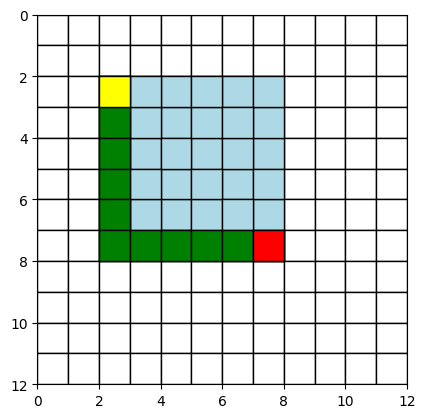

In [7]:
import matplotlib.pyplot as plt

# Function to plot the nodes visited by the algorithm
def visualize_grid(grid_size, path, visited):
    fig, ax = plt.subplots()

    # Draw grid
    for x in range(grid_size):
        for y in range(grid_size):
            rect = plt.Rectangle((x, y), 1, 1, edgecolor='black', facecolor='white')
            ax.add_patch(rect)

    # Highlight visited nodes
    for node in visited:
        rect = plt.Rectangle((node[0], node[1]), 1, 1, edgecolor='black', facecolor='lightblue')
        ax.add_patch(rect)

    # Highlight path
    for node in path:
        rect = plt.Rectangle((node[0], node[1]), 1, 1, edgecolor='black', facecolor='green')
        ax.add_patch(rect)

    # Highlight start and goal
    rect = plt.Rectangle((path[0][0], path[0][1]), 1, 1, edgecolor='black', facecolor='yellow')
    ax.add_patch(rect)
    rect = plt.Rectangle((path[-1][0], path[-1][1]), 1, 1, edgecolor='black', facecolor='red')
    ax.add_patch(rect)

    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()
    plt.show()


def grid_heuristic(node):
    goal = (7, 7)
    return abs(node[0] - goal[0]) + abs(node[1] - goal[1])

grid_graph = WeightedGraph()
grid_size = 12

for x in range(grid_size):
    for y in range(grid_size):
        if x < grid_size - 1:
            grid_graph.add_edge(((x, y), (x + 1, y)), 1)
        if y < grid_size - 1:
            grid_graph.add_edge(((x, y), (x, y + 1)), 1)

start_node = (2, 2)
goal_node = (7, 7)
path, cost, visited = a_star(grid_graph, start_node, goal_node, grid_heuristic)

if path:
    print(f"Shortest path: {path} with cost {cost}")
    visualize_grid(grid_size, path, visited)
else:
    print("No path found")

